<a href="https://colab.research.google.com/github/Teiyui/The-treasure-of-ZYW/blob/master/ai_missing_pixels_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dmc27/missing_pixels.git

Cloning into 'missing_pixels'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (59/59), done.


In [31]:
import os.path
from os import listdir
from os.path import isfile, join

import cv2 as cv

from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import resnet
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
import cv2

NUM_INP_NODES = 60
NUM_OUT_NODES = 4
BLOCK_SIZE = 8
M1 = 3
M2 = 4
C1 = 0
C2 = 7

In [4]:
def is_missing_pixel(r, c):
  return (r >= M1 and c >= M1 and r <= M2 and c <= M2)

def do_parse_img(img, inps, tgts):
  num_rows = img.shape[0]
  num_cols = img.shape[1]

  inp = np.zeros((NUM_INP_NODES))
  tgt = np.zeros((NUM_OUT_NODES))

  for r0 in range(0, num_rows, BLOCK_SIZE):
    for c0 in range(0, num_cols, BLOCK_SIZE):      
      # extract and reshape a block of the image
      pos1 = 0
      pos2 = 0
      for r in range(BLOCK_SIZE):
        for c in range(BLOCK_SIZE):
          assert(r0 + r < num_rows)          
          assert(c0 + c < num_cols)

          if is_missing_pixel(r, c):
            tgt[pos2] = img[r0 + r, c0 + c]
            pos2 += 1
          else:
            inp[pos1] = img[r0 + r, c0 + c]
            pos1 += 1
               
      # add the input and target patterns
      inps.append(inp.copy() / 255.0)
      tgts.append(tgt.copy() / 255.0)


def imshow(img, cmap=None, vmin=0, vmax=255, frameon=False, dpi=72):
  fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi], \
                   frameon=frameon)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()


['cactus.bmp', 'lily.bmp', 'zelda.bmp', 'peak.bmp', 'dune2.bmp', 'rainriver.bmp', 'rabbits.bmp', 'frog.bmp', 'helen.bmp', 'pelicans.bmp', 'buds.bmp', 'horse.bmp', 'bark.bmp', 'branches.bmp', 'desert.bmp', 'deer.bmp', 'fox.bmp', 'kid.bmp', 'WALL.BMP', 'sealion.bmp', 'sheep.bmp', '1fnoise.bmp', 'FOOTBALL.BMP', 'hawaii.bmp', 'SAIL.BMP', 'lena.bmp', 'TRAIN.BMP', 'KIDS.BMP', 'tank.bmp', 'balloon.bmp', 'beans.bmp', 'pony.bmp', 'barn.bmp', 'bridge.bmp', 'FLOWERS.BMP', 'bricks.bmp', 'peppers.bmp', 'barbara.bmp', 'bushes.bmp', 'eagle.bmp', 'PUMPKINS.BMP', 'TABLE.BMP', 'HOUSE.BMP', 'BEACH.BMP', 'duck.bmp', 'tulips.bmp', 'valley.bmp', 'birds.bmp', 'airplane.bmp', 'fruits.bmp', 'rooster.bmp', 'baboon.bmp', 'man.bmp', 'baby.bmp', 'stream.bmp']
cactus.bmp


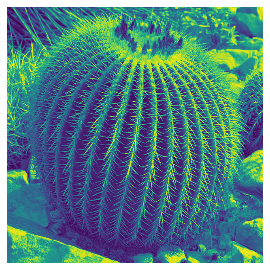

lily.bmp


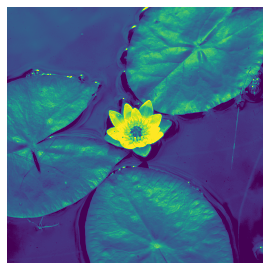

zelda.bmp


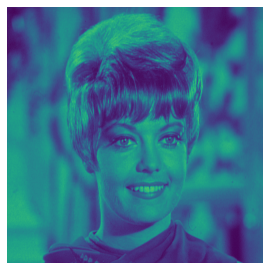

peak.bmp


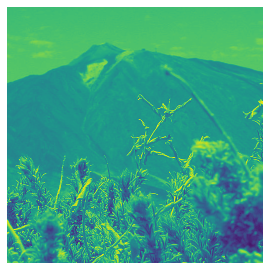

dune2.bmp


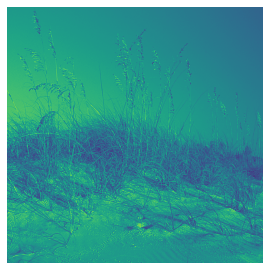

rainriver.bmp


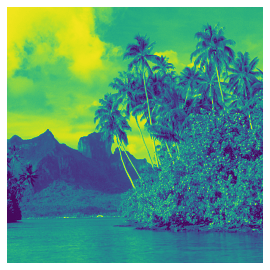

rabbits.bmp


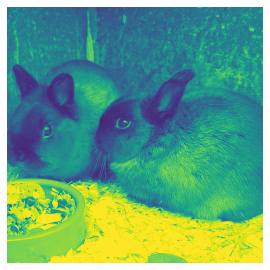

frog.bmp


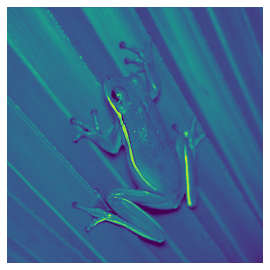

helen.bmp


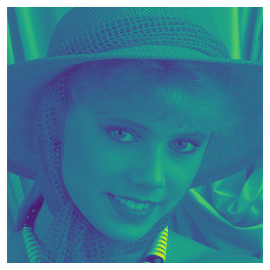

pelicans.bmp


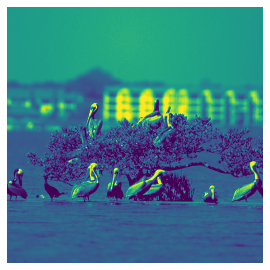

buds.bmp


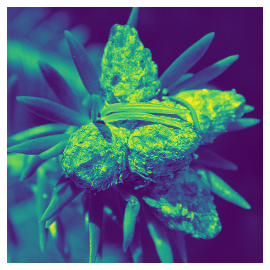

horse.bmp


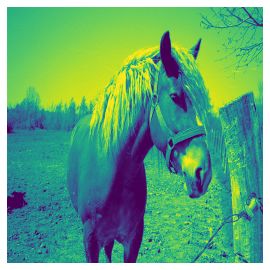

bark.bmp


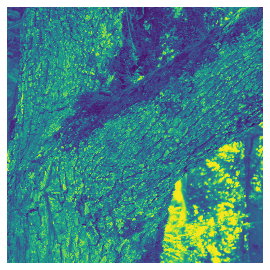

branches.bmp


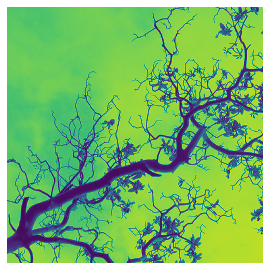

desert.bmp


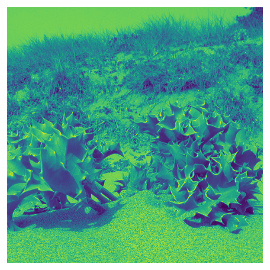

deer.bmp


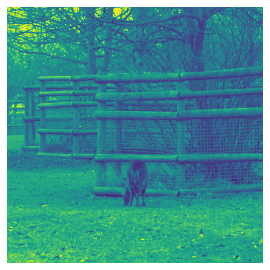

fox.bmp


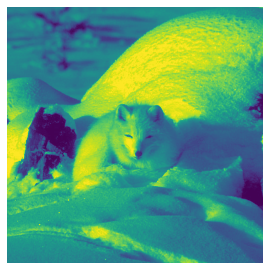

kid.bmp


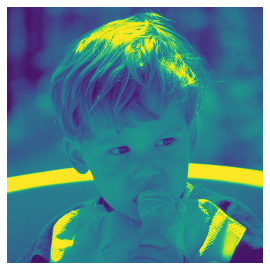

WALL.BMP


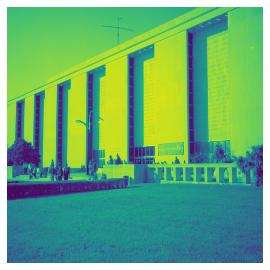

sealion.bmp


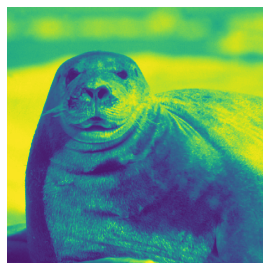

sheep.bmp


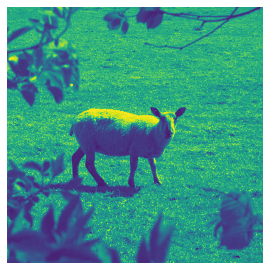

1fnoise.bmp


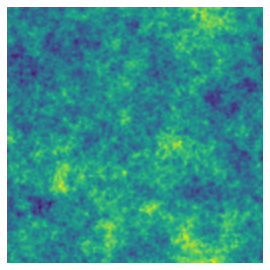

FOOTBALL.BMP


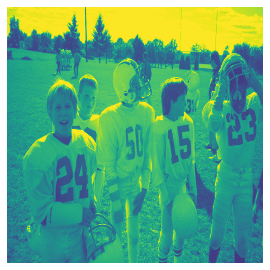

hawaii.bmp


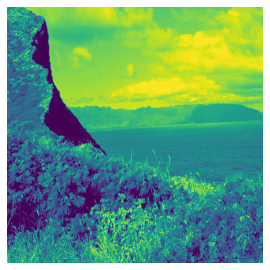

SAIL.BMP


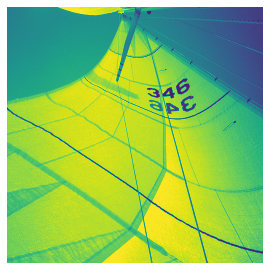

lena.bmp


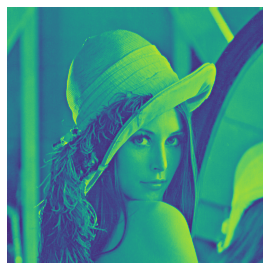

num_imgs = 26
[0.01568627 0.01960784 0.03137255 0.05490196 0.11764706 0.43921569
 0.56470588 0.37254902 0.06666667 0.00784314 0.00784314 0.01568627
 0.09019608 0.25882353 0.63921569 0.50980392 0.23137255 0.18431373
 0.04705882 0.         0.00392157 0.06666667 0.35686275 0.79607843
 0.16862745 0.2        0.18431373 0.         0.06666667 0.57647059
 0.1254902  0.0745098  0.16078431 0.04705882 0.         0.17254902
 0.10196078 0.12941176 0.09019608 0.09019608 0.11764706 0.11764706
 0.0745098  0.03529412 0.04705882 0.03529412 0.1254902  0.16470588
 0.06666667 0.06666667 0.12156863 0.14509804 0.1254902  0.
 0.01176471 0.1254902  0.25882353 0.2        0.11372549 0.10980392]


In [34]:
#%% LOAD THE TRAINING DATA
img_path = "/content/missing_pixels"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames)

inps = []
tgts = []
num_imgs = 0
for img_fname in img_fnames:

  # skip the image(s) used for testing
  if (img_fname.lower() == "balloon.bmp"):
    continue

  print(img_fname)
  img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
  img = cv.resize(img, (256, 256), cv.INTER_LINEAR)
  img = img.astype(np.float64)
  # cv2_imshow(img)
  imshow(img)

  do_parse_img(img, inps, tgts)

  num_imgs += 1
  if (num_imgs > 25):
    break

print("num_imgs =", num_imgs)

X_trn = np.zeros((len(inps), NUM_INP_NODES))
y_trn = np.zeros((len(tgts), NUM_OUT_NODES))
for idx in range(len(inps)):
  X_trn[idx, :] = inps[idx]
  y_trn[idx] = tgts[idx]
print(X_trn[0])


In [64]:
#%% CREATE OR LOAD THE MODEL
reuse_pre_model = False

# previous model exists?
model_fname = "model.0.h5"

# New
# resnet_model = Sequential()
# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(None, NUM_INP_NODES,),
#                    pooling='avg',classes=5,
#                    weights='imagenet')
# for layer in pretrained_model.layers:
#         layer.trainable=False

# resnet_model.add(pretrained_model)
# resnet_model.add(LSTM(32, input_shape=(None, NUM_INP_NODES,)))
# resnet_model.add(Flatten())
# resnet_model.add(Dense(90, activation='relu'))
# resnet_model.add(Dense(60, activation='relu'))
# resnet_model.add(Dense(NUM_OUT_NODES, activation='softmax'))
# resnet_model.compile(loss="mean_squared_error", optimizer="adam",
#     metrics=["accuracy"])
# resnet_model.summary()
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=2, kernel_size=3,
  input_shape=[256, 256, 8], activation="relu"))
cnn_model.add(Conv2D(filters=2, kernel_size=3,
  input_shape=[64, 64, 8], activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
# hidden layer
cnn_model.add(Dense(24, activation="relu"))
# output layer
cnn_model.add(Dense(4, activation="sigmoid"))

cnn_model.compile(loss="mean_squared_error",
  optimizer="adam", metrics=["accuracy"])
# model.compile(loss="categorical_crossentropy", 
#   optimizer="adam", metrics=["accuracy"])

cnn_model.summary()


if reuse_pre_model and os.path.exists(model_fname):
  print("Reloading previous model: ", model_fname)
  model = load_model(model_fname)
else:
  print("Creating new model")
  model = Sequential()
  model.add(Dense(42, input_shape=(NUM_INP_NODES,), 
    activation="relu"))
  model.add(Dense(36, activation="relu"))
  model.add(Dense(30, activation="relu"))
  model.add(Dense(24, activation="relu"))
  model.add(Dense(NUM_OUT_NODES, activation='sigmoid'))

  # compile the keras model
  model.compile(loss="mean_squared_error", optimizer="adam",
    metrics=["accuracy"])
  cnn_model = model

# show the model info
# model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 254, 254, 2)       146       
                                                                 
 conv2d_30 (Conv2D)          (None, 252, 252, 2)       38        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 126, 126, 2)      0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 31752)             0         
                                                                 
 dense_73 (Dense)            (None, 24)                762072    
                                                                 
 dense_74 (Dense)            (None, 4)                 100       
                                                     

# New Section

# New Section

In [65]:
# DO THE TRAINING
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1, 
  save_best_only=True)
callbacks_list = [checkpoint]

# fit the model
# print(X_trn[0])
history = cnn_model.fit(X_trn, y_trn, epochs=500, batch_size=512,
  validation_split=0.25, callbacks=callbacks_list)


Epoch 1/500
37/39 [===========================>..] - ETA: 0s - loss: 0.0474 - accuracy: 0.2791
Epoch 1: loss improved from inf to 0.04700, saving model to model.0.h5
39/39 [==============================] - 1s 9ms/step - loss: 0.0470 - accuracy: 0.2775 - val_loss: 0.0316 - val_accuracy: 0.2335
Epoch 2/500
21/39 [===============>..............] - ETA: 0s - loss: 0.0302 - accuracy: 0.2693
Epoch 2: loss improved from 0.04700 to 0.02236, saving model to model.0.h5
39/39 [==============================] - 0s 4ms/step - loss: 0.0224 - accuracy: 0.2691 - val_loss: 0.0060 - val_accuracy: 0.2844
Epoch 3/500
22/39 [===============>..............] - ETA: 0s - loss: 0.0086 - accuracy: 0.2947
Epoch 3: loss improved from 0.02236 to 0.00814, saving model to model.0.h5
39/39 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.2920 - val_loss: 0.0040 - val_accuracy: 0.2931
Epoch 4/500
18/39 [============>.................] - ETA: 0s - loss: 0.0070 - accuracy: 0.3079
Epoch 4: los

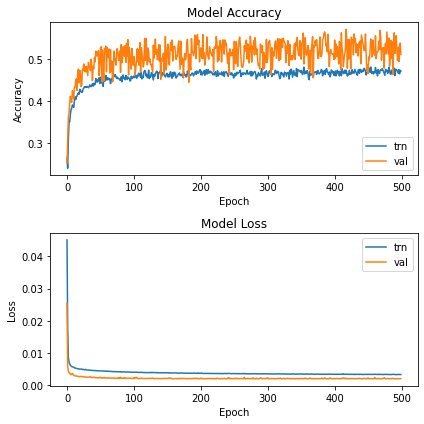

In [63]:
fig = plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='upper right')
plt.tight_layout()


MSE = 20.68


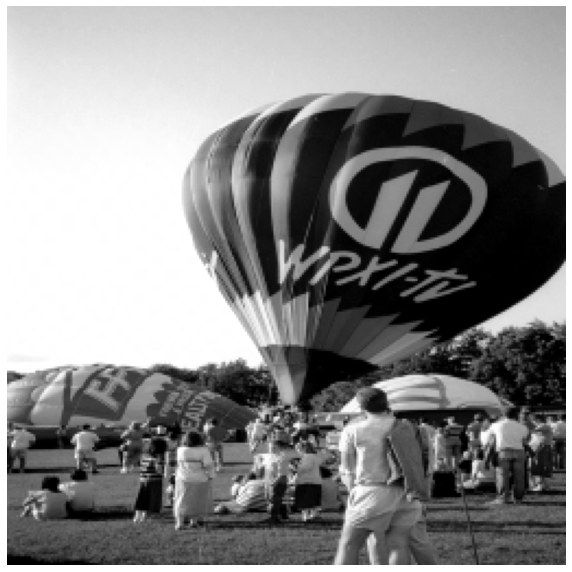

(0.0, 1.0, 0.0, 1.0)

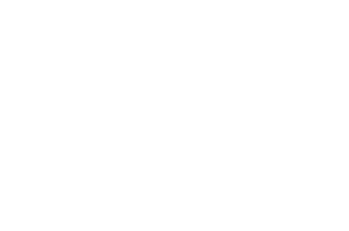

In [39]:
img = cv.imread(join(img_path, "balloon.bmp"), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

img1 = cv.imread(join(img_path, "cactus.bmp"), cv.IMREAD_GRAYSCALE)
img1 = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img1 = img.astype(np.float64)

inps = []
tgts = []
do_parse_img(img, inps, tgts)

X_tst = np.zeros((len(inps), NUM_INP_NODES))
y_tst = np.zeros((len(tgts), NUM_OUT_NODES))
for idx in range(len(inps)):
  X_tst[idx, :] = inps[idx]
  y_tst[idx] = tgts[idx]
  
# predict the missing pixels
y_tst_prd = model.predict(X_tst)

num_rows = img.shape[0]
num_cols = img.shape[1]
rec_img = np.zeros((num_rows, num_cols))

blk_pos = 0
for r0 in range(0, num_rows, BLOCK_SIZE):
  for c0 in range(0, num_cols, BLOCK_SIZE):      
    # fill in the outer and context pixels
    for r in range(BLOCK_SIZE):
      for c in range(BLOCK_SIZE):
        assert(r0 + r < num_rows)
        assert(c0 + c < num_cols)
        if not is_missing_pixel(r, c):
          rec_img[r0 + r, c0 + c] = img[r0 + r, c0 + c]

    out = y_tst_prd[blk_pos]
    blk_pos += 1

    # fill in the missing pixels
    pos = 0
    for r in range(BLOCK_SIZE):
      for c in range(BLOCK_SIZE):
        assert(r0 + r < num_rows)
        assert(c0 + c < num_cols)
        if is_missing_pixel(r, c):
          rec_img[r0 + r, c0 + c] = 255*out[pos]
          pos += 1

# compute the MSE between the original and reconstructed images
err = rec_img - img 
print("MSE =", "{:.2f}".format((err**2).mean()))

imshow(img1, "gray", dpi=33)
plt.axis("off")
